Waterbirds with Attribute Annotation
===

---

### *Notebook Overview*:
This notebook presents a detailed evaluation of our proposed method, **Diverse Prototypical Ensembles (DPE)**, on the Waterbirds dataset. The dataset is a standard benchmark for studying subpopulation shift, where the goal is to build models that maintain high accuracy across both majority and minority subgroups.

Waterbirds consists of images labeled by bird type (landbird vs. waterbird), along with a spurious attribute: background (land vs. water). This attribute introduces strong correlations in the training data (for example, most landbirds appear on land), creating subgroups with varying levels of representation. As a result, models trained via standard Empirical Risk Minimization (ERM) tend to perform poorly on underrepresented combinations such as landbirds on water.

This notebook is organized into multiple steps that highlight the challenges and solutions surrounding subpopulation shift.

In [1]:
%load_ext autoreload
%autoreload 2

import sys

sys.path.append('..')

from utils.misc import fix_random_seed

fix_random_seed(0)

## 1. The Dataset: Waterbirds

We begin by preparing the validation and test splits for the Waterbirds dataset.

Each data point is associated with:
- A **class label** (0: landbird, 1: waterbird)
- An **attribute label** (0: land background, 1: water background)
- A derived **subgroup name** that defines the four possible combinations of class and attribute

This structure allows us to evaluate models not only on overall accuracy but also on **worst-group accuracy (WGA)**, which is the accuracy on the most underrepresented subgroup.

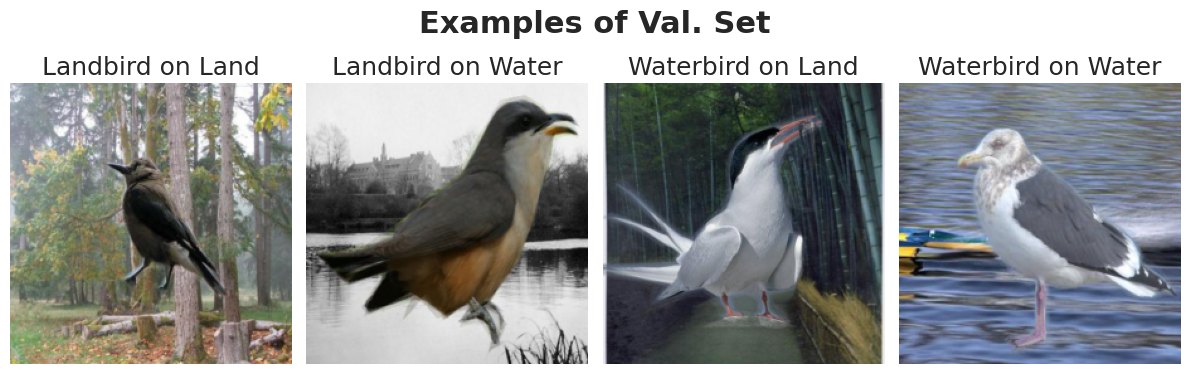

In [2]:
import numpy as np
from torch.utils.data import DataLoader

from utils import datasets as dsets
from notebooks.src.utils_plot import show_examples, plot_distributions

dataset_name = 'Waterbirds'
data_dir = '/scratch/ssd004/scratch/minht/datasets/'

datasets, dataloaders = dict(), dict()
datasets['val'] = vars(dsets)[dataset_name](data_dir, 'va', None)
datasets['test'] = vars(dsets)[dataset_name](data_dir, 'te', None)
datasets['train_eval'] = vars(dsets)[dataset_name](data_dir, 'tr', None)

set_name = 'val'
groups_dict = {'00': 'Landbird on Land', '01': 'Landbird on Water', '10': 'Waterbird on Land',
               '11': 'Waterbird on Water'}
show_examples(datasets, groups_dict, set_name)

## 2. Visualizing Group Structure

To gain intuition about the nature of the subpopulation shift, we visualize image samples from each group in the validation set. The four subgroups are:
- Landbird on Land (majority)
- Landbird on Water (minority)
- Waterbird on Land (minority)
- Waterbird on Water (majority)

We also plot the group distribution, which shows a clear class-attribute imbalance in the training data. This imbalance often leads ERM to overfit to majority subgroups while ignoring the tail cases.

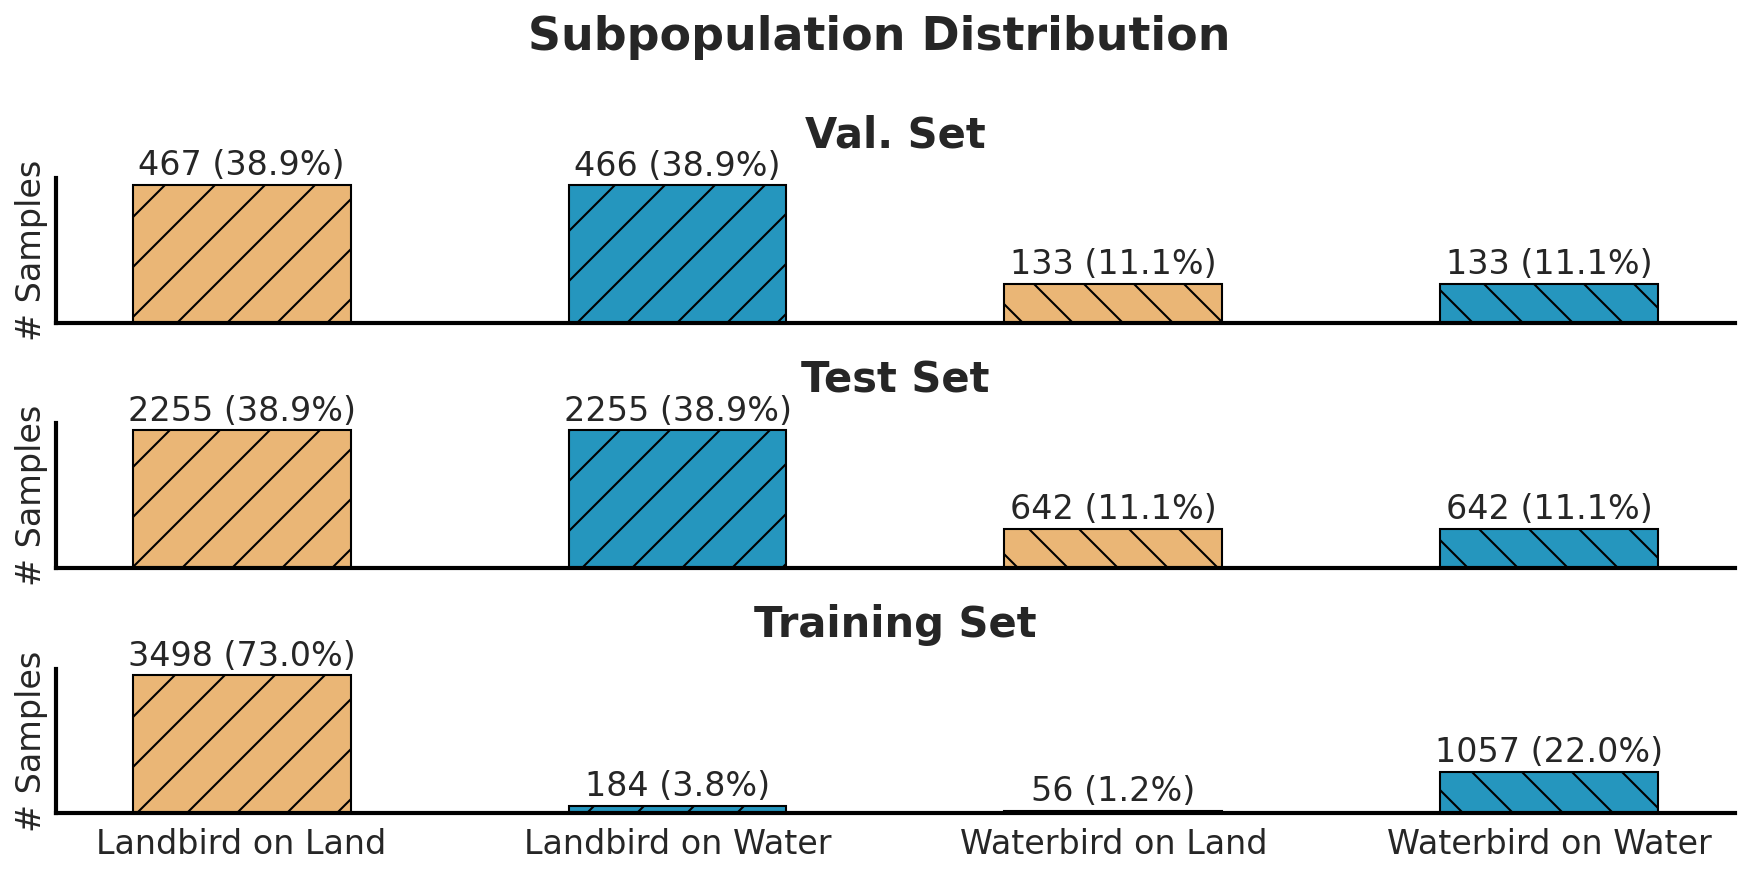

In [3]:
plot_distributions(datasets, groups_dict)

## 3. Feature Pre-extraction

To accelerate training, we precompute features using a frozen ResNet-50 backbone and store them as NumPy arrays. These feature representations are then used as input to train lightweight classifiers (ERM head or prototype-based head) in downstream steps.

This setup simulates the frozen-feature regime in which we aim to improve robustness by modifying only the classifier head.

In [4]:
workers = 10
batch_size_train, batch_size_eval = 256, 256
ckpt_dir = '/scratch/ssd004/scratch/minht/checkpoints/sd0/Waterbirds/13574640/'


def get_pre_extracted_features(_ckpt_dir: str, _set_name: str) -> np.ndarray:
    pre_extracted_feats = np.load(f'{_ckpt_dir}/feats_{_set_name}.npy', mmap_mode='r')
    pre_extracted_feats = ((pre_extracted_feats - pre_extracted_feats.mean(axis=1, keepdims=True)) /
                           pre_extracted_feats.std(axis=1, keepdims=True))
    return pre_extracted_feats


for set_name in ['val', 'test']:
    datasets[set_name].feats = get_pre_extracted_features(ckpt_dir, set_name)
    dataloaders[set_name] = DataLoader(dataset=datasets[set_name], num_workers=workers, pin_memory=False,
                                       batch_size=batch_size_eval, shuffle=False, drop_last=False)

## 4. Baseline Evaluation with ERM

We evaluate an ERM classifier trained on the biased training set using the frozen ResNet-50 features. The per-group accuracy plot shows that while ERM performs well on dominant subgroups, it fails significantly on minority ones, particularly landbirds on water and waterbirds on land. The accuracy of ~72% on this subgroup is the **baseline worst group accuracy**.

> This confirms the subpopulation shift challenge. Minimizing average error does not guarantee equitable performance across all groups.

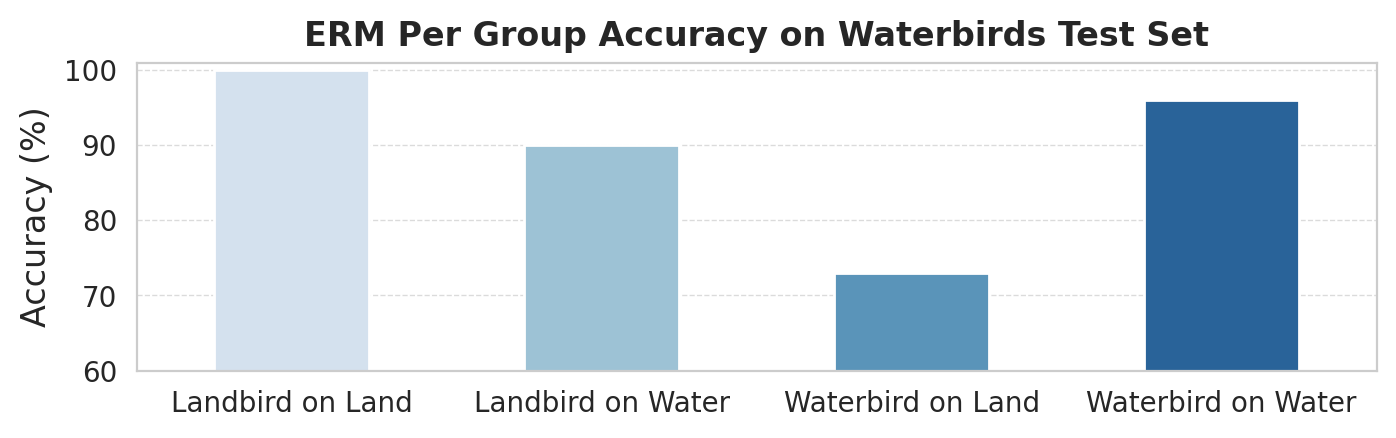

In [5]:
import torch
import torchvision
from torch import nn
from tqdm import tqdm
from utils.eval_helpers import eval_metrics, get_acc
from notebooks.src.utils_plot import show_erm_per_group_accuracy

ckpt_dir = '/scratch/ssd004/scratch/minht/checkpoints/sd0/Waterbirds/13574640/'


def init_erm_model(_ckpt_path, num_classes=2, device='cuda'):
    ckpt = torch.load(_ckpt_path, map_location="cpu")
    _model = torchvision.models.resnet50()
    backbone = torch.nn.Sequential(*list(_model.children())[:-1])
    emb_dim = _model.fc.in_features
    head = nn.Linear(emb_dim, num_classes)

    _model = nn.Sequential(backbone, nn.Flatten(), head)
    _model.load_state_dict(ckpt, strict=True)
    _model.to(device)
    return _model


def evaluate(_model, eval_loader, device='cuda'):
    ds = eval_loader.dataset
    classes, attributes, groups = np.array(ds.y), np.array(ds._a), np.array(ds.g)
    _model.eval()
    all_preds = []
    with torch.no_grad():
        for *_, feats in eval_loader:
            feats = feats.to(device)
            outputs = _model[-1](feats)
            all_preds.append(outputs.detach().softmax(1).cpu())
        all_preds = torch.concat(all_preds, dim=0).numpy()
        _res = eval_metrics(all_preds, np.array(classes), np.array(attributes), np.array(groups))
    return _res


erm_model = init_erm_model(ckpt_dir + 'ckpt_last.pt')
results = dict()
results['ERM'] = evaluate(erm_model, dataloaders['test'])
show_erm_per_group_accuracy(results['ERM'], groups_dict)

## 5. Constructing a Balanced Subset for Prototype Training

To mitigate group imbalance, we create a new training set by subsampling the validation set to ensure better group coverage. This balanced subset serves as the foundation for training our prototype ensemble members in Stage-1+.

Unlike traditional approaches that retrain a single classifier on a balanced set, our goal is to train a **diverse ensemble** of classifiers. Each classifier is specialized in covering different parts of the feature embedding space.

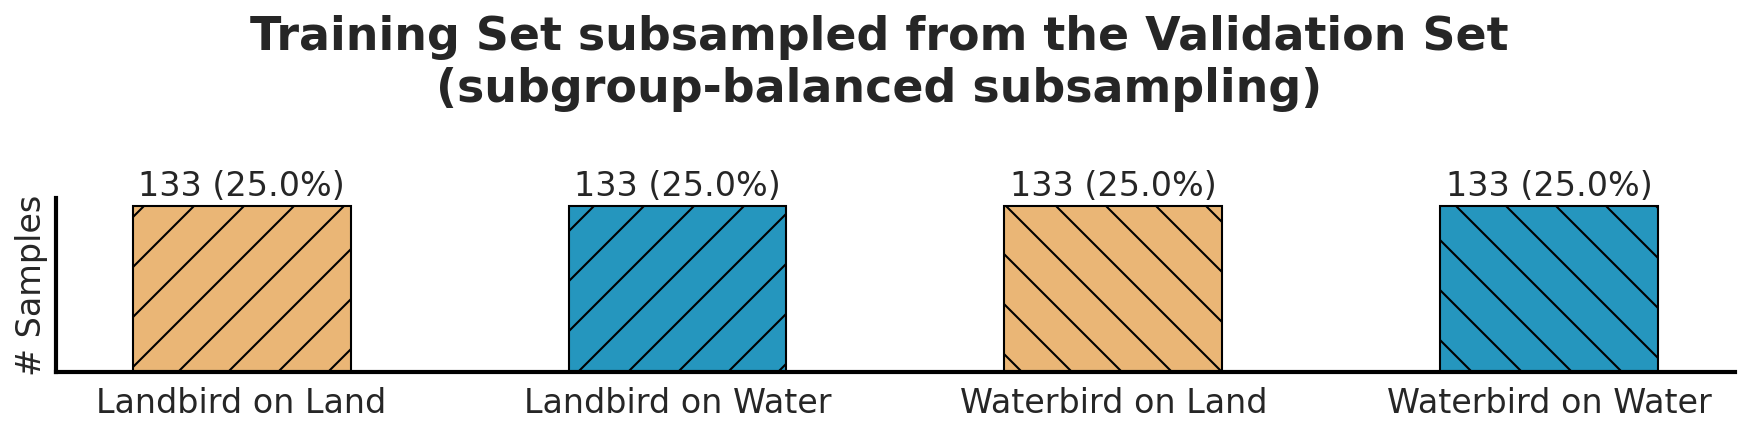

In [19]:
def get_subsampled_train_set(_datasets=None, train_attr='yes', subsample_type='group', _dataset_name='Waterbirds', trn_split='va'):
    if _datasets is None:
        pre_extracted_feats = None
        _datasets = {}
    else:
        pre_extracted_feats = _datasets['val'].feats
    _datasets['train'] = vars(dsets)[_dataset_name](
        data_dir, trn_split, None, train_attr=train_attr, subsample_type=subsample_type,
        pre_extracted_feats=pre_extracted_feats)
    return _datasets


def get_train_loader(_datasets, attr_availability='yes'):
    _datasets = get_subsampled_train_set(_datasets, attr_availability)
    train_loader = DataLoader(_datasets['train'], batch_size=batch_size_train, drop_last=True, shuffle=True,
                              num_workers=workers, pin_memory=False)
    return train_loader


plot_distributions(get_subsampled_train_set(), groups_dict, fig_size=(12, 3),
                   title='Training Set subsampled from the Validation Set\n(subgroup-balanced subsampling)',
                   set_name_dict={'train': ''})

## 6. Training and Evaluating Diverse Prototype Ensembles

The next four cells contain the main logic for initializing, training, and evaluating our Diverse Prototypical Ensemble (DPE) method. The flow is organized as follows:

1. **Model Initialization (`init_model`)**
   This function defines and returns a prototype-based classifier (IsoMax+) with a frozen backbone. The model is configured with one prototype per class and operates on pre-extracted features.

2. **Prototype Head Training (`train_prototypes`)**
    This function trains a single ensemble member using a balanced subset of the validation set. The prototypes are optimized to minimize classification loss, with an additional inter-prototype similarity loss applied to encourage diversity across members. After each epoch, the model is evaluated on the validation set, and the version achieving the highest worst-group accuracy is retained as an ensemble member.

3. **Ensemble Training Loop (`train_ensemble`)**
   We train multiple prototype heads independently by repeatedly calling `train_prototypes`, each time using a different randomly sampled balanced subset generated by `get_train_loader`. Based on our analysis, training 15 ensemble members, each for 20 epochs, provides a favorable trade-off between performance and computational cost.

4. **Ensemble Evaluation (`evaluate_ensemble`)**
   The trained heads are combined by averaging their logits at inference. This function computes the worst-group accuracy of the ensemble on the test set.

Together, these functions implement the core of our DPE training pipeline under subpopulation shift.


In [7]:
from utils.isomaxplus import IsoMaxPlusLossFirstPart


def init_model(_ckpt_path, num_classes=2, _model=None, device='cuda'):
    """The backbone is frozen so we only load it once"""
    if _model is None:
        ckpt = torch.load(_ckpt_path, map_location="cpu")
        _model = torchvision.models.resnet50()
        backbone = torch.nn.Sequential(*list(_model.children())[:-1])
        emb_dim = _model.fc.in_features
        head = IsoMaxPlusLossFirstPart(emb_dim, num_classes)

        _model = nn.Sequential(backbone, nn.Flatten(), head)
        _model.load_state_dict(ckpt, strict=False)
        _model.emb_dim = emb_dim
    else:
        assert hasattr(_model, "emb_dim")
        _model[-1] = IsoMaxPlusLossFirstPart(_model.emb_dim, num_classes)
    _model.to(device)
    return _model

In [8]:
from utils.isomaxplus import IsoMaxPlusLossSecondPart


def train_prototypes(train_loader, val_loader, model, _prototype_ensemble=(),
                     epochs=20, cov_reg=5e5, wd_weight=10, device='cuda',
                     entropic=30, lr=1e-3, _stage=1, verbose=True):
    best_val_wga, val_wga = 0.0, 0.0
    best_val_wga_prototype = None

    criterion = IsoMaxPlusLossSecondPart(entropic_scale=entropic, reduction='mean')
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    if len(_prototype_ensemble) > 0:
        _prototype_ensemble = torch.concat([_[0] for _ in _prototype_ensemble], dim=1).detach()

    for epoch in range(epochs):
        model.train()
        running_loss, running_clf, running_cov, running_correct, total = 0.0, 0.0, 0.0, 0, 0
        pbar = tqdm(train_loader, desc=f"[Stage {_stage}] Epoch {epoch + 1}",
                    leave=(epoch == epochs - 1) and verbose)

        for _, _, labels, _, _, feats in pbar:
            feats = feats.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model[-1](feats)
            clf_loss = criterion(outputs, labels)

            head = model[-1]
            wd = torch.einsum('ijk,ilk->ijl', [head.prototypes[:, None], head.prototypes[:, None]]) * wd_weight
            wd = wd.squeeze().mean()
            loss = clf_loss + wd

            cov_loss = torch.tensor(0.0, device=device)
            if len(_prototype_ensemble) and (cov_reg > 0):
                _prototypes = torch.cat([head.prototypes[:, None], _prototype_ensemble], dim=1)
                n_pro, n_dim = _prototypes.shape[1:]
                cov = torch.einsum('ijk,ilk->ijl', [_prototypes, _prototypes]) / (n_dim - 1)
                cov_loss = torch.abs(cov[:, 0, 1:].sum(1).div(n_pro).mean())
                loss += cov_loss * cov_reg

            loss.backward()
            optimizer.step()

            preds = outputs.argmax(dim=1)
            correct = (preds == labels).sum().item()
            running_loss += loss.item()
            running_clf += clf_loss.item()
            running_cov += cov_loss.item()
            running_correct += correct
            total += labels.size(0)

            pbar.set_postfix({
                'loss': running_loss / (total // labels.size(0)),
                'clf': running_clf / (total // labels.size(0)),
                'cov': running_cov / (total // labels.size(0)),
                'acc': f"{running_correct / total:.2%}",
                'val wga': f"{val_wga:.2%}"
            })

        val_wga = evaluate(model, val_loader)['min_group']['accuracy']
        if val_wga >= best_val_wga:
            best_val_wga = val_wga
            best_val_wga_prototype = [
                model[-1].prototypes[:, None].detach().clone(),
                model[-1].distance_scale.detach().clone()
            ]

    return best_val_wga_prototype


def cov_reg_scheduler_inv(_cov_reg, _num_stages, alpha=0.05):
    scheduler = [_cov_reg / (1 + alpha * _) for _ in range(_num_stages)]
    scheduler = [_cov_reg] + scheduler

    def cov_reg_schedule(_stage):
        _stage = max(_stage, 1)
        return scheduler[_stage - 1]

    return cov_reg_schedule

In [9]:
def train_ensemble(init_model_func, _datasets, _dataloaders, cov_reg=5e5, random_subset=True, num_stages=15, show_freq=15, seed=0,
                   epochs=20, attr_availability='yes'):
    fix_random_seed(seed)
    full_model = None
    prototype_ensemble = []
    ensemble_wga, ensemble_acc, ensemble_balanced_acc = [], [], []
    _train_prototypes = partial(train_prototypes, val_loader=_dataloaders['val'],
                                epochs=epochs, wd_weight=10, device='cuda', entropic=30, lr=1e-3)
    cv_scheduler = cov_reg_scheduler_inv(cov_reg, num_stages)
    train_loader = get_train_loader(_datasets, attr_availability=attr_availability)

    for stage in range(1, num_stages + 1):
        verbose = stage % show_freq == 0 or stage == 1 or stage == num_stages + 1
        full_model = init_model_func(_model=full_model)
        prototype_ensemble.append(_train_prototypes(
            train_loader, model=full_model,
            _prototype_ensemble=prototype_ensemble, _stage=stage, verbose=verbose,
            cov_reg=cv_scheduler(stage),
        ))
        res = evaluate_ensemble(prototype_ensemble, _dataloaders['test'], full_model, device='cuda', verbose=verbose)
        ensemble_wga.append(res['min_group']['accuracy'])
        ensemble_acc.append(res['overall']['accuracy'])
        ensemble_balanced_acc.append(res['overall']['balanced_acc'])

        if stage <= num_stages + 1 and random_subset:
            train_loader = get_train_loader(_datasets, attr_availability)
    return ensemble_wga, ensemble_balanced_acc, res

In [10]:
def evaluate_ensemble(_prototype_ensemble, eval_loader, _model, device='cuda', show_individuals=False, verbose=True):
    dist_scales = [_[1].detach() for _ in _prototype_ensemble]
    clf = torch.concat([_[0] for _ in _prototype_ensemble], dim=1).detach().transpose(0, 1)
    preds_list = torch.zeros(clf.shape[0], len(eval_loader.dataset), eval_loader.dataset.num_labels)

    ds = eval_loader.dataset
    classes, attributes, groups = np.array(ds.y), np.array(ds._a), np.array(ds.g)

    position = 0

    with torch.no_grad():
        for *_, feats in tqdm(eval_loader, leave=False):
            feats = feats.to(device)

            for i, _weight in enumerate(clf):
                _model[-1].prototypes = torch.nn.Parameter(_weight, requires_grad=False)
                _model[-1].distance_scale = nn.Parameter(dist_scales[i], requires_grad=False)
                _model.eval()
                preds_list[i][position:position + feats.shape[0]] = _model[-1](feats.squeeze())
            position += feats.shape[0]

    if show_individuals:
        for i in range(preds_list.shape[0] - 1, -1, -1):
            preds = preds_list[i].softmax(1).argmax(1).numpy()
            get_acc(preds, classes, groups)

    get_acc(preds_list.softmax(2).mean(0).argmax(1).numpy(), classes, groups, verbose=verbose)

    preds = preds_list.softmax(2).mean(0).detach().cpu().numpy()
    _res = eval_metrics(preds, classes, attributes, groups)
    if verbose:
        print(f"Ensemble WGA: {_res['min_group']['accuracy'] * 100:.1f}")
    return _res

In [11]:
from functools import partial

train_ensemble_func = partial(
    train_ensemble, _datasets=datasets, _dataloaders=dataloaders,
    init_model_func=partial(init_model, _ckpt_path=ckpt_dir + 'ckpt_last.pt', device='cuda')
)
metrics = dict()
metrics['DPE'] = train_ensemble_func(cov_reg=5e5, random_subset=True)

[Stage 1] Epoch 20: 100%|██████████| 2/2 [00:00<00:00,  5.30it/s, loss=0.111, clf=0.0478, cov=0, acc=98.63%, val wga=92.70%]


Avg ACC: 0.953
ACC per group: [0.97, 0.956, 0.916, 0.921]
Ensemble WGA: 91.6


[Stage 15] Epoch 20: 100%|██████████| 2/2 [00:00<00:00,  5.31it/s, loss=0.182, clf=0.0787, cov=2.2e-7, acc=98.63%, val wga=93.35%]  


Avg ACC: 0.961
ACC per group: [0.982, 0.945, 0.945, 0.956]
Ensemble WGA: 94.5


In [12]:
# DPE without inter-prototype similarity regularization
metrics['Random subset'] = train_ensemble_func(cov_reg=0, random_subset=True)

[Stage 1] Epoch 20: 100%|██████████| 2/2 [00:00<00:00,  5.04it/s, loss=0.111, clf=0.0478, cov=0, acc=98.63%, val wga=92.70%]


Avg ACC: 0.953
ACC per group: [0.97, 0.956, 0.916, 0.921]
Ensemble WGA: 91.6


[Stage 15] Epoch 20: 100%|██████████| 2/2 [00:00<00:00,  4.72it/s, loss=0.0921, clf=0.0364, cov=0, acc=99.22%, val wga=96.14%]


Avg ACC: 0.963
ACC per group: [0.982, 0.958, 0.933, 0.942]
Ensemble WGA: 93.3


In [13]:
# DPE without diversification
metrics['No diversification'] = train_ensemble_func(cov_reg=0, random_subset=False)

[Stage 1] Epoch 20: 100%|██████████| 2/2 [00:00<00:00,  4.49it/s, loss=0.111, clf=0.0478, cov=0, acc=98.63%, val wga=92.70%]


Avg ACC: 0.953
ACC per group: [0.97, 0.956, 0.916, 0.921]
Ensemble WGA: 91.6


[Stage 15] Epoch 20: 100%|██████████| 2/2 [00:00<00:00,  4.72it/s, loss=0.0975, clf=0.0365, cov=0, acc=98.83%, val wga=95.28%]


Avg ACC: 0.961
ACC per group: [0.98, 0.957, 0.928, 0.941]
Ensemble WGA: 92.8


## 7. Ensemble Evaluation and Diversity Regularization

As the number of ensemble members increases, the ensemble improves its coverage of the feature space.

We conduct ablation experiments to assess the effectiveness of this diversification:
- with **inter-prototype similarity loss**, which penalizes overlap between the learned prototypes across ensemble members.
- Without diversity loss, ensemble members may collapse to similar regions.

Performance is measured by worst-group accuracy on the test set, plotted against the number of prototypes in the ensemble.

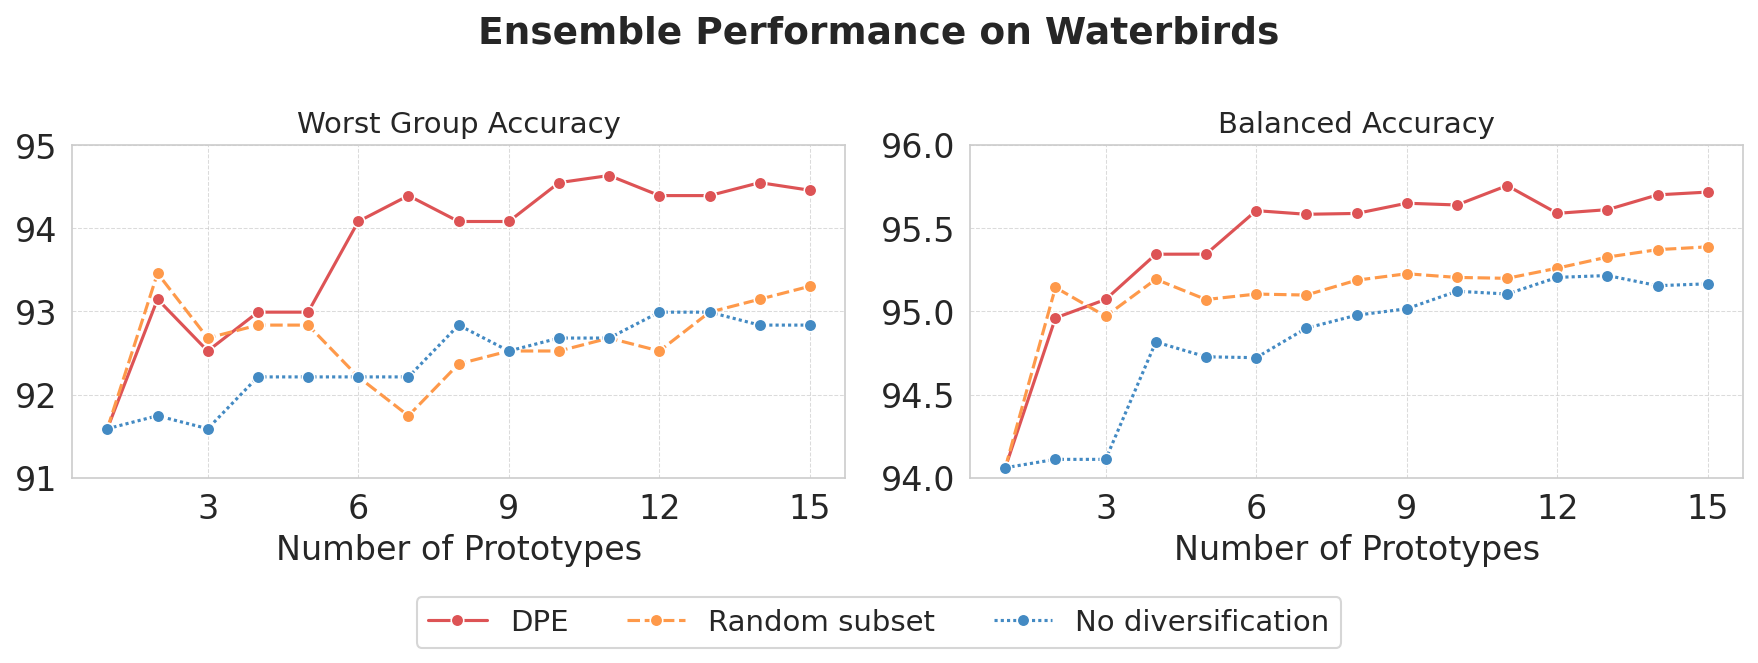

In [17]:
import pylab as plt
from notebooks.src.utils_plot import dict_to_df, plot_metrics

df = dict_to_df(metrics)
fig, axes = plt.subplots(1, 2, figsize=(12, 4), dpi=150)
plot_metrics(df, 'Worst Group Accuracy', axes[0])
plot_metrics(df, 'Balanced Accuracy', axes[1], show_legend=True)

## 8. Final Comparison: ERM vs. DPE

We conclude by comparing per-group accuracy between:
- The ERM baseline
- DPE without diversity regularization
- DPE with diversity regularization

DPE consistently improves the accuracy of underrepresented groups while maintaining performance on majority groups. This highlights its effectiveness in improving robustness under subpopulation shift, even when group labels are only partially available.

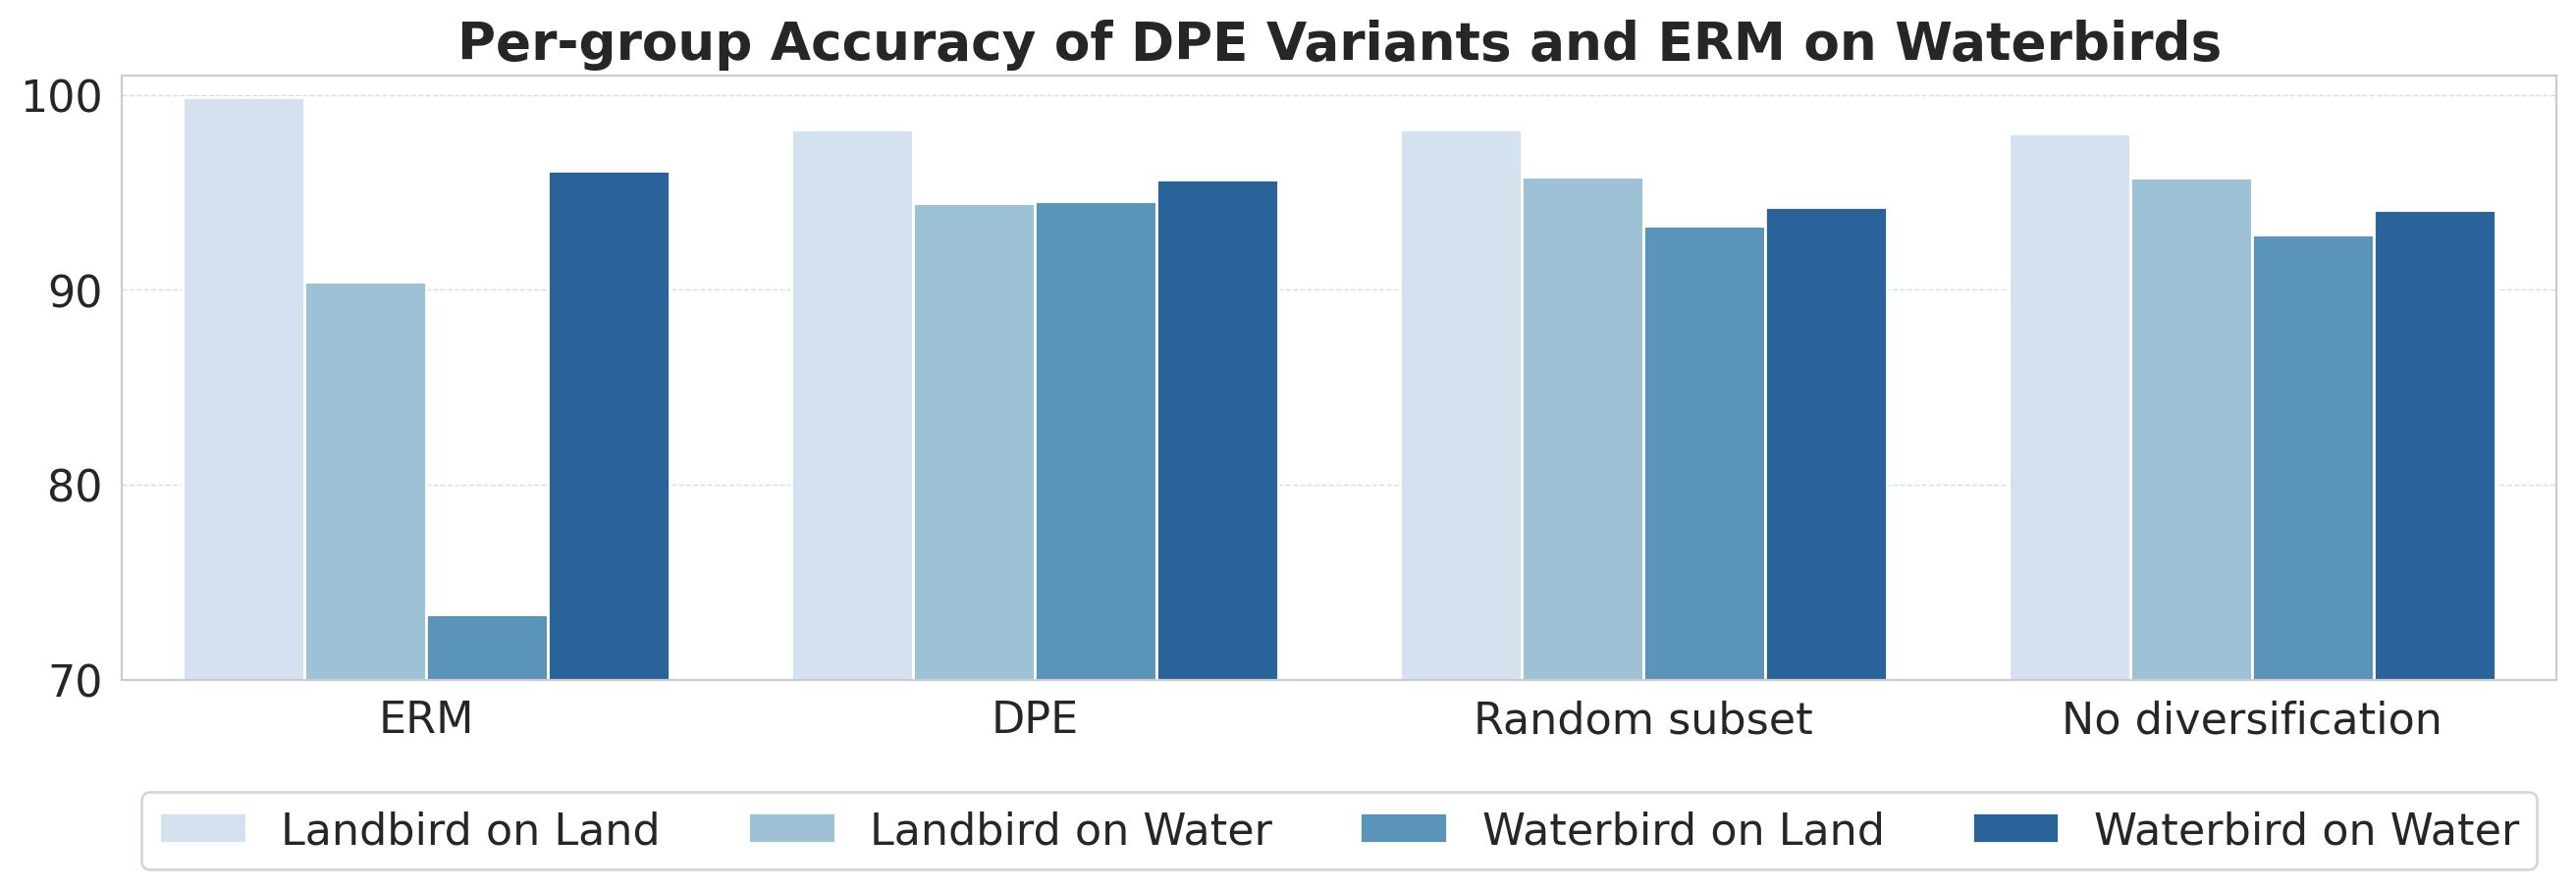

In [22]:
import pylab as plt
import pandas as pd

palette = ['#377eb8', '#4daf4a', '#984ea3', '#ff7f00', '#a65628', '#f781bf']

results = dict()
results['ERM'] = evaluate(erm_model, dataloaders['test'])
for k in metrics.keys():
    results[k] = metrics[k][-1]

df2 = []
for k in results.keys():
    per_group_acc = results[k]['per_group']
    tmp = {g: per_group_acc[g]['accuracy']*100 for g in per_group_acc.keys()}
    df2.append(pd.DataFrame(tmp.values(), columns=['Accuracy']))
    df2[-1]['Group'] = [groups_dict[kk] for kk in tmp.keys()]
    df2[-1]['Diversification Strategy'] = k
df2 = pd.concat(df2)
df2.reset_index(drop=True, inplace=True)
import seaborn as sns

plt.figure(figsize=(16, 4), dpi=200)
ax = sns.barplot(
    data=df2, x='Diversification Strategy', y='Accuracy', hue='Group',
    palette=sns.color_palette('Blues', len(df2['Group'].unique())),
    # palette=sns.color_palette(palette, 4)
)
ax.set_ylim(70, 101)
ax.set_xlabel('')
ax.set_ylabel('')
ax.grid(True, which='major', linestyle='--', linewidth=0.5, alpha=0.7, axis='y')

# Move legend below the x-axis label
ax.legend(
    # title='Group',
    loc='upper center',
    bbox_to_anchor=(0.5, -0.15),
    ncol=len(df2['Group'].unique()),
    frameon=True
)
_ = plt.title('Per-group Accuracy of DPE Variants and ERM on Waterbirds', weight='bold')

# Remark
---
By combining balanced data sampling, distance-based classification, and inter-prototype regularization, Diverse Prototypical Ensembles offer a simple and effective solution for subgroup-aware learning. The methods demonstrated here generalize beyond Waterbirds to other structured robustness benchmarks.

---